In [37]:
from graph_tool.all import *
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import torch
import pickle
from multiprocessing import Process, Value, Array
from pyvis.network import Network
import graph_tool as gt
import numpy as np


In [38]:
K = 100

In [102]:

adjs = np.fromfile('output.bin', dtype=np.uint32).reshape(-1, K)
adj_dic = {}
g = gt.Graph()
for i, adj in zip(range(adjs.shape[0]), adjs):
    for x in adj:
        g.add_edge(i, x)
g

<Graph object, directed, with 1000000 vertices and 100000000 edges, at 0x7f505e6875e0>

In [61]:
# with open('output_graph_iter2.pkl', 'wb') as f:
#     pickle.dump(g, f)
#     f.close()


In [138]:
# Open the file in binary read mode
with open('output_graph.pkl', 'rb') as f:
    
    # Load the object from the file
    g = pickle.load(f)
    
    # Close the file
    f.close()


In [139]:
g

<Graph object, directed, with 1000000 vertices and 100000000 edges, at 0x7f505e582b20>

In [140]:
vid = np.arange(0, g.num_vertices()).tolist()
all_ind = g.get_in_degrees(vid)
ind_df = pd.DataFrame(all_ind)
ind_df

,0
0,104
1,64
2,73
3,55
4,22
...,...
999995,30
999996,128
999997,43
999998,110


In [141]:
ind_df.describe()

,0
count,1000000.000000
mean,100.000000
std,171.873161
min,0.000000
25%,29.000000
50%,57.000000
75%,109.000000
max,10658.000000


In [142]:
f_gt = open('../evaluation-code/contest-data-release-gt-1m.ibin', 'rb')
f_gt.seek(4)
gt_ids = np.empty((1000000, K), dtype=np.uint32)
for i in range(1000000):
    cur_id = np.fromfile(f_gt, dtype=np.uint32, count=1)[0]
    gt_ids[cur_id] = np.fromfile(f_gt, dtype=np.uint32, count=K)


In [172]:
gt_graph = gt.Graph()
for i in range(gt_ids.shape[0]):
    for x in gt_ids[0]:
        gt_graph.add_edge(i, x)
gt_graph

In [ ]:
# with open('output_graph_iter2.pkl', 'wb') as f:
#     pickle.dump(g, f)
#     f.close()

In [144]:
f_res = open('output.bin', 'rb')
graph_res = np.fromfile(f_res, dtype=np.uint32).reshape(-1, K)
f_res.close()

for i in range(graph_res.shape[0]):
    unique_vals = np.unique(graph_res[i])
    if len(unique_vals) == graph_res.shape[1]:
        pass
        # print("All elements in graph_res[{}] are unique".format(i))
    else:
        print("There are duplicate elements in graph_res[{}]: {}".format(i, unique_vals))


In [145]:
graph_res

array([[513548, 964580, 510954, ..., 450783, 703797, 368286],
       [182423, 555328, 481001, ..., 244628,  46471, 552387],
       [654596, 319311, 115908, ..., 702534, 416532, 429405],
       ...,
       [259154, 542208, 864029, ..., 366741, 878759, 802517],
       [616694, 916714, 838316, ..., 771087, 233660, 186672],
       [ 65364, 769904, 391230, ..., 528604, 294449, 582554]],
      dtype=uint32)

In [146]:
graph_res[1], gt_ids[1]

(array([182423, 555328, 481001, 870285, 105516, 379912, 767419, 234646,
         14593, 611263, 823224, 800336, 375059, 176962, 287145, 879562,
         30211, 691407, 662105, 236970, 797638, 478318,  57877, 929959,
        765426, 403352, 293805, 155457, 558088, 252996, 501898, 297621,
        262514, 636335, 111451, 782534, 791048, 648460, 819288, 889686,
        900516, 772471, 728079, 240993, 527817, 983340, 926564, 413899,
        951558, 485810, 215059, 227659, 524707, 449789, 879774, 945364,
        314083, 445653, 387173, 913225, 860499, 499465, 481872, 116577,
         56237, 836803, 662816, 757656, 319471, 891329, 900657, 769486,
        187863, 491194, 257503, 190437, 909537, 774366, 597076, 839464,
        495226, 292169, 977571, 578385, 421420, 132079, 728161, 759135,
        532606, 480445, 873091, 747105, 665991, 554666, 870334, 324055,
        566492, 244628,  46471, 552387], dtype=uint32),
 array([182423, 555328, 481001, 870285, 105516, 379912, 767419, 234646,
        

In [147]:
a = np.isin(gt_ids[1], graph_res[1])
a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [148]:
import multiprocessing as mp

def process_chunk(start_idx, end_idx):
    chunk_hit_mx = np.zeros((end_idx-start_idx, K), dtype=np.uint32)
    for i in range(start_idx, end_idx):
        mask = np.isin(gt_ids[i], graph_res[i])
        hit_indices = np.where(mask)[0]
        gt_indices = np.where(mask == True)[0]
        chunk_hit_mx[i-start_idx, gt_indices] = 1
    return chunk_hit_mx

# number of worker processes
num_procs = mp.cpu_count()

# chunk size
chunk_size = 10**4

# create pool of worker processes
pool = mp.Pool(processes=num_procs)

# submit jobs to pool
results = []
for i in range(0, 10**6, chunk_size):
    results.append(pool.apply_async(process_chunk, args=(i, min(i+chunk_size, 10**6))))

# collect results and combine into final hit_mx array
hit_mx = np.concatenate([r.get() for r in results], axis=0)

# close pool
pool.close()
pool.join()


In [150]:
import multiprocessing as mp

def process_chunk(start_idx, end_idx):
    chunk_in_gt_mx = np.zeros((end_idx-start_idx, K), dtype=np.uint32)
    for i in range(start_idx, end_idx):
        mask = np.isin(graph_res[i], gt_ids[i])
        hit_indices = np.where(mask == True)[0]
        # gt_indices = np.where(mask == True)[0]
        chunk_in_gt_mx[i-start_idx, hit_indices] = 1
    return chunk_in_gt_mx

# number of worker processes
num_procs = mp.cpu_count()

# chunk size
chunk_size = 10**4

# create pool of worker processes
pool = mp.Pool(processes=num_procs)

# submit jobs to pool
results = []
for i in range(0, 10**6, chunk_size):
    results.append(pool.apply_async(process_chunk, args=(i, min(i+chunk_size, 10**6))))

# collect results and combine into final hit_mx array
res_in_gt_mx = np.concatenate([r.get() for r in results], axis=0)

# close pool
pool.close()
pool.join()


In [162]:
res_in_gt_df = pd.DataFrame(res_in_gt_mx)
res_in_gt_df['recall'] = res_in_gt_df.sum(axis=1) / K
res_in_gt_df.describe(percentiles=np.arange(0, 1, 0.1))

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,recall
count,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.976283,0.964373,0.947329,0.923445,0.890018,0.843602,0.777756,0.679643,0.511206,0.984735
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.152166,0.185358,0.223376,0.265884,0.312867,0.363232,0.415754,0.466614,0.499875,0.023803
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000
0%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000
10%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950000
20%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.970000
30%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.980000
40%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.990000
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [169]:
res_in_gt_dgree_df = pd.DataFrame({'recall': res_in_gt_df['recall'], 'indegree': all_ind})
check_low_degree_ids = res_in_gt_dgree_df[res_in_gt_dgree_df['indegree'] < 30].index.tolist()

In [170]:
# res_in_gt_dgree_df[res_in_gt_dgree_df['indegree'] < 30].describe(percentiles=np.arange(0, 1, 0.1))
res_in_gt_dgree_df.loc[check_low_degree_ids].describe()

,recall,indegree
count,259760.000000,259760.000000
mean,0.966249,16.806460
std,0.031738,7.613237
min,0.700000,0.000000
25%,0.950000,11.000000
50%,0.970000,17.000000
75%,0.990000,23.000000
max,1.000000,29.000000


In [171]:
temp_gt = gt_ids[check_low_degree_ids,:]
temp_gt

array([[126736, 822158,  86291, ..., 788157, 170660, 831658],
       [852650, 575158, 978794, ..., 890248, 249781, 968516],
       [139478, 888771, 878955, ..., 221272, 680823, 806732],
       ...,
       [396207, 102840, 539300, ..., 699379,  20698, 466189],
       [878743,  23340, 527434, ..., 731936, 583239, 718855],
       [ 65364, 769904, 391230, ..., 820345, 370596, 528604]],
      dtype=uint32)

In [149]:
hit_df = pd.DataFrame(hit_mx)
hit_df['recall'] = hit_df.sum(axis=1) / K

In [115]:
recall_ind_df = pd.DataFrame({'recall': hit_df['recall'], 'indegree': all_ind})
recall_ind_df

,recall,indegree
0,0.89,100
1,0.51,46
2,0.65,53
3,0.77,44
4,0.73,20
...,...,...
999995,0.72,28
999996,0.87,139
999997,0.61,52
999998,0.80,101


<Axes: xlabel='indegree', ylabel='recall'>

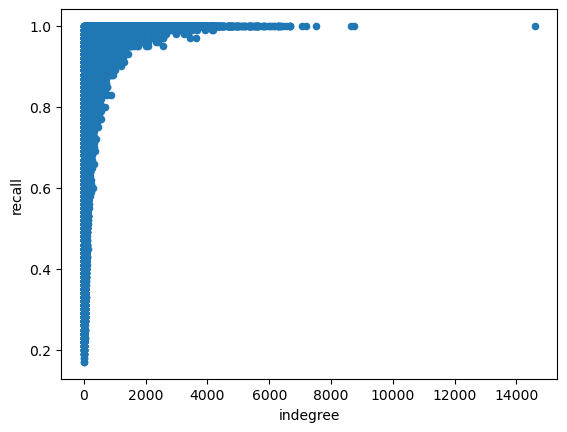

In [118]:
sorted_df = recall_ind_df.sort_values(by='indegree')
sorted_df.plot(x='indegree', y='recall', kind='scatter')

In [119]:
sorted_df.describe(percentiles=np.arange(0, 1, 0.1))

,recall,indegree
count,1000000.000000,1000000.00000
mean,0.759159,100.00000
std,0.163924,195.63499
min,0.170000,0.00000
0%,0.170000,0.00000
10%,0.520000,11.00000
20%,0.610000,19.00000
30%,0.680000,28.00000
40%,0.740000,37.00000
50%,0.780000,49.00000


In [136]:
low_recall_ids = sorted_df[sorted_df['indegree'] > 2000].index.tolist()
low_recall_gt = gt_ids[low_recall_ids, :]
low_recall_gt.shape

(1677, 100)

In [137]:
sorted_df.loc[low_recall_ids, :].describe(percentiles=np.arange(0, 1, 0.01))

,recall,indegree
count,1677.000000,1677.000000
mean,0.998986,2893.134168
std,0.004496,945.952572
min,0.950000,2001.000000
0%,0.950000,2001.000000
...,...,...
96%,1.000000,4976.120000
97%,1.000000,5358.720000
98%,1.000000,5620.240000
99%,1.000000,6288.680000


In [135]:
sorted_df.loc[low_recall_gt.flatten()].describe(percentiles=np.arange(0, 1, 0.1))

,recall,indegree
count,334500.000000,334500.000000
mean,0.980234,1327.882410
std,0.056636,1177.780395
min,0.320000,2.000000
0%,0.320000,2.000000
10%,0.940000,177.000000
20%,0.990000,345.000000
30%,1.000000,540.000000
40%,1.000000,754.000000
50%,1.000000,1004.000000


In [88]:
low_recall_hit_mx = hit_mx[low_recall_ids, :]
loc_1_ij = np.where(low_recall_hit_mx == 1)
loc_0_ij = np.where(low_recall_hit_mx == 0)
low_recall_hit = []
low_recall_miss = []
for i, j in zip(loc_1_ij[0], loc_1_ij[1]):
    low_recall_hit.append(low_recall_gt[i][j])
    
for i, j in zip(loc_0_ij[0], loc_0_ij[1]):
    low_recall_miss.append(low_recall_gt[i][j])

In [89]:
len(low_recall_miss), len(low_recall_hit)

(10311091, 14143009)

In [90]:
sorted_df.loc[low_recall_hit].describe(percentiles=np.arange(0, 1, 0.05))

,recall,indegree
count,1.414301e+07,1.414301e+07
mean,8.575216e-01,3.106310e+02
std,1.376442e-01,5.596071e+02
min,2.000000e-01,1.000000e+00
0%,2.000000e-01,1.000000e+00
5%,5.700000e-01,2.200000e+01
10%,6.500000e-01,3.300000e+01
15%,7.000000e-01,4.200000e+01
20%,7.400000e-01,5.200000e+01
25%,7.800000e-01,6.200000e+01


In [91]:
sorted_df.loc[low_recall_miss].describe(percentiles=np.arange(0, 1, 0.1))

,recall,indegree
count,1.031109e+07,1.031109e+07
mean,8.075388e-01,1.714015e+02
std,1.507752e-01,2.831267e+02
min,2.000000e-01,0.000000e+00
0%,2.000000e-01,0.000000e+00
10%,5.800000e-01,2.400000e+01
20%,6.700000e-01,3.800000e+01
30%,7.400000e-01,5.200000e+01
40%,7.900000e-01,6.800000e+01
50%,8.400000e-01,8.800000e+01


In [100]:
sorted_df[sorted_df['indegree'] < 600].describe(percentiles=np.arange(0, 1, 0.1))

,recall,indegree
count,981083.000000,981083.000000
mean,0.792813,80.457897
std,0.150215,91.424250
min,0.200000,0.000000
0%,0.200000,0.000000
10%,0.570000,12.000000
20%,0.660000,19.000000
30%,0.730000,28.000000
40%,0.780000,38.000000
50%,0.820000,49.000000


In [34]:
hit_loc_mean_df = pd.DataFrame(hit_df.describe().loc['mean'])

In [ ]:
# pd.set_option('display.max_rows', None)
hit_loc_mean_df['id'] = hit_loc_mean_df.index.tolist()
hit_loc_mean_df

In [17]:
# Function to find reverse k-nearest neighbors
def reverse_knn(adj_list, k):
    # Initialize empty dictionary to store rKNN counts
    rknn_counts = {}
    # Iterate over every vertex in the graph
    for i, vertex in enumerate(adj_list):
        # Initialize count of rKNNs to 0
        count_rknn = 0
        # Iterate over every other vertex in the graph
        for j, other_vertex in enumerate(adj_list):
            # Skip the current vertex
            if i == j:
                continue
            # If the current vertex is one of the K nearest neighbors of the other vertex,
            # increment the rKNN count of the current vertex
            if i in other_vertex[:k]:
                count_rknn += 1
        # Store the rKNN count of the current vertex in the dictionary
        rknn_counts[i] = count_rknn
    # Return the dictionary of rKNN counts
    return rknn_counts
